In [2]:
#:author: Philipp Steen

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
import matplotlib.mlab as mlab
import math

In [3]:
def GaussFWHM(R_vals, display_label):
    (mu, sigma) = norm.fit(R_vals)
    n, bins, patches = plt.hist(R_vals, density=True, color = "orange", alpha = 0.5)
    xax = np.linspace(bins[0], bins[-1], 1000)
    y = norm.pdf(xax, mu, sigma)
    sigma_coords = [mu-sigma, mu+sigma]
    FWHM = 2.354820045*sigma
    FWHM_coords = [mu-0.5*FWHM, mu+0.5*FWHM]
    plt.plot(xax,y, color = "red")
    plt.axvline(FWHM_coords[0], color = "black")
    plt.axvline(FWHM_coords[1], color = "black")
    plt.axvline(sigma_coords[0], color = "blue")
    plt.axvline(sigma_coords[1], color = "blue")
    plt.title(display_label)
    #plt.show()
    plt.close()
    return(FWHM)

def circles(R1_table, R1_sizes, color, edge, show_labels, alpha1, textcolor, labels):
    for count, value in enumerate(R1_table):
        draw_circle = plt.Circle((value[0], value[1]), R1_sizes[count], 
                                 alpha=alpha1, facecolor = color, edgecolor = edge)
        ax.add_artist(draw_circle)
        if show_labels==True:
            ax.text(value[0]+2.5, value[1]-1, str(round(labels[count], 2))+" nm", color = textcolor)

In [4]:

#No spacer, 5x and 7x repeat
input_path_R1 = "/in-R1.hdf5"
input_path_R3 = "/in-R3.hdf5"

#Read in data
R1_table = pd.read_hdf(input_path_R1, key = 'locs')
R3_table = pd.read_hdf(input_path_R3, key = 'locs')
R1_table.sort_values(by=['group', 'frame'])
R3_table.sort_values(by=['group', 'frame'])

#Find innermost data points to adjust field of view for the plot
Minx = min(R1_table["x"].min(), R3_table["x"].min())*130 -5
Miny = max(R1_table["y"].max(), R3_table["y"].max())*130 +5

#Find outermost data points to adjust field of view for the plot
maxOuter = max(((max(R1_table["x"].max(), R3_table["x"].max())*130)-Minx), 
               (-(min(R1_table["y"].min(), R3_table["y"].min())*130)+Miny)) +5

#Transform data points from pixels to nanometers and set the bottom left of the plot to 0,0
R1_table["x"] = 130*R1_table["x"]-Minx
R3_table["x"] = 130*R3_table["x"]-Minx
R1_table["y"] = -(130)*R1_table["y"]+Miny
R3_table["y"] = -(130)*R3_table["y"]+Miny

In [5]:
###########################################################
##                                                       ##
##  This section takes care of the R4 (alignment) sites  ##
##                                                       ##
###########################################################

R4_positions_R1_channel = []
R4_std_R1_channel = []
R4_positions_R3_channel = []
R4_std_R3_channel = []
R4_FWHM_R1_channel = []
R4_FWHM_R3_channel = []

#These pick (group) numbers correspond to R4 sites
for i in (0,1,8,9,10,11):
#for i in (0,1,2,3,10,11):
    R1 = (R1_table[R1_table["group"] == i])
    Avg_R1 = R1["x"].mean(), R1["y"].mean()
    Std_R1 = R1["x"].std(), R1["y"].std()
    
    FWHM_x = GaussFWHM(R1["x"], ("R4 (R1 channel), spot "+str(i)+" x"))
    FWHM_y = GaussFWHM(R1["y"], ("R4 (R1 channel), spot "+str(i)+" y"))
    
    FWHM_R1 = [FWHM_x, FWHM_y]
    
    R3 = (R3_table[R3_table["group"] == i])
    Avg_R3 = R3["x"].mean(), R3["y"].mean()
    Std_R3 = R3["x"].std(), R3["y"].std()
    
    FWHM_x = GaussFWHM(R3["x"], ("R4 (R3 channel), spot "+str(i)+" x"))
    FWHM_y = GaussFWHM(R3["y"], ("R4 (R3 channel), spot "+str(i)+" y"))
    
    FWHM_R3 = [FWHM_x, FWHM_y]
    
    R4_positions_R1_channel.append(Avg_R1)
    R4_std_R1_channel.append(Std_R1)
    R4_FWHM_R1_channel.append(FWHM_R1)
    R4_positions_R3_channel.append(Avg_R3)
    R4_std_R3_channel.append(Std_R3)
    R4_FWHM_R3_channel.append(FWHM_R3)
    
#Turn the lists into numpy arrays for better usability
R4_positions_R1_channel = np.asarray(R4_positions_R1_channel)
R4_positions_R3_channel = np.asarray(R4_positions_R3_channel)
R4_std_R1_channel = np.asarray(R4_std_R1_channel)
R4_std_R3_channel = np.asarray(R4_std_R3_channel)
R4_FWHM_R1_channel = np.asarray(R4_FWHM_R1_channel)
R4_FWHM_R3_channel = np.asarray(R4_FWHM_R3_channel)

#Calculate distances in x and y as well as the direct distance
R4_differences = (R4_positions_R1_channel - R4_positions_R3_channel)
R4_distances = (np.sqrt(R4_differences[:,0]**2 + R4_differences[:,1]**2))
print("dx and dy: \n", R4_differences)
print("Distances: \n", R4_distances)

#Find the average FWHM (from x and y FWHM)
R4_FWHM_R1_channel_avg = np.mean(R4_FWHM_R1_channel, axis = 1)
R4_FWHM_R3_channel_avg = np.mean(R4_FWHM_R3_channel, axis = 1)
print("R1 channel FWHM: \n", R4_FWHM_R1_channel_avg)
print("R3 channel FWHM: \n", R4_FWHM_R3_channel_avg)

#Find the average standard deviation (from x and y std)
R4_std_R1_channel_avg = np.mean(R4_std_R1_channel, axis = 1)
R4_std_R3_channel_avg = np.mean(R4_std_R3_channel, axis = 1)
print("R1 channel STD: \n", R4_std_R1_channel_avg)
print("R3 channel STD: \n", R4_std_R3_channel_avg)

dx and dy: 
 [[ 0.06419086 -0.04321289]
 [ 0.026577   -0.30912018]
 [-0.33473587 -0.16635704]
 [ 0.33980751 -0.07595682]
 [-0.8717041   0.38016796]
 [ 0.07776642 -0.16025543]]
Distances: 
 [0.07738101 0.31026057 0.37379509 0.34819331 0.95099722 0.17812754]
R1 channel FWHM: 
 [2.51081767 2.33589576 2.18805322 2.95381023 2.8318169  3.03089776]
R3 channel FWHM: 
 [3.18823777 2.74080064 2.08226335 2.84177644 3.39897089 2.98696031]
R1 channel STD: 
 [1.07857299 1.00292483 0.93968019 1.26822859 1.22842646 1.30233628]
R3 channel STD: 
 [1.37209427 1.1780194  0.89716536 1.22178322 1.46650612 1.28594196]


In [6]:
######################################################
##                                                  ##
##  This section takes care of the R1 and R3 sites  ##
##                                                  ##
######################################################

R1_resi = []
R1_resi_std = []
R3_resi = []
R3_resi_std = []
R1_FWHM = []
R3_FWHM = []

#These pick (group) numbers correspond to R1 and R3 sites
for i in (2,3,4,5,6,7):
#for i in (4,5,6,7,8,9):
    R1 = (R1_table[R1_table["group"] == i])
    Avg_R1 = R1["x"].mean(), R1["y"].mean()
    Std_R1 = R1["x"].std(), R1["y"].std()
    
    FWHM_x = GaussFWHM(R1["x"], ("R1, spot "+str(i)+" x"))
    FWHM_y = GaussFWHM(R1["y"], ("R1, spot "+str(i)+" y"))
    
    FWHM_R1 = [FWHM_x, FWHM_y]
    
    R3 = (R3_table[R3_table["group"] == i])
    Avg_R3 = R3["x"].mean(), R3["y"].mean()
    Std_R3 = R3["x"].std(), R3["y"].std()
    
    FWHM_x = GaussFWHM(R3["x"], ("R3, spot "+str(i)+" x"))
    FWHM_y = GaussFWHM(R3["y"], ("R3, spot "+str(i)+" y"))
    
    FWHM_R3 = [FWHM_x, FWHM_y]
    
    R1_resi.append(Avg_R1)
    R1_resi_std.append(Std_R1)
    R1_FWHM.append(FWHM_R1)
    R3_resi.append(Avg_R3)
    R3_resi_std.append(Std_R3)
    R3_FWHM.append(FWHM_R3)
        
#Turn the lists into numpy arrays for better usability
R1_resi = np.asarray(R1_resi)
R3_resi = np.asarray(R3_resi)
R1_resi_std = np.asarray(R1_resi_std)
R3_resi_std = np.asarray(R3_resi_std)
R1_FWHM = np.asarray(R1_FWHM)
R3_FWHM = np.asarray(R3_FWHM)

#Calculate distances in x and y as well as the direct distance
Resi_differences = (R1_resi - R3_resi)
Resi_distances = (np.sqrt(Resi_differences[:,0]**2 + Resi_differences[:,1]**2))
print("dx and dy: \n", Resi_differences)
print("Distances: \n", Resi_distances)

#Find the average FWHM (from x and y FWHM)
R1_FWHM_avg = np.mean(R1_FWHM, axis = 1)
R3_FWHM_avg = np.mean(R3_FWHM, axis = 1)
print("R1 FWHM: \n", R1_FWHM_avg)
print("R3 FWHM: \n", R3_FWHM_avg)

#Find the average standard deviation (from x and y std)
R1_resi_std_avg = np.mean(R1_resi_std, axis = 1)
R3_resi_std_avg = np.mean(R3_resi_std, axis = 1)
print("R1 STD: \n", R1_resi_std_avg)
print("R3 STD: \n", R3_resi_std_avg)

dx and dy: 
 [[ 0.10658979  0.76128387]
 [ 0.26124191  0.59460831]
 [-0.26275253  0.64113617]
 [ 0.25401306  0.30308914]
 [ 0.01988983  0.70576096]
 [ 0.31166458  0.71416092]]
Distances: 
 [0.76870965 0.64946622 0.69288851 0.39545627 0.70604117 0.77920513]
R1 FWHM: 
 [2.02832839 1.77070959 2.58077263 2.76088744 3.28031796 2.51616742]
R3 FWHM: 
 [2.68014512 2.45731663 3.10520228 3.03212042 2.33692086 2.92331446]
R1 STD: 
 [0.87291414 0.76129255 1.11195332 1.18737721 1.41123301 1.08367497]
R3 STD: 
 [1.15194923 1.05648983 1.33635885 1.30250931 1.00414366 1.25646532]


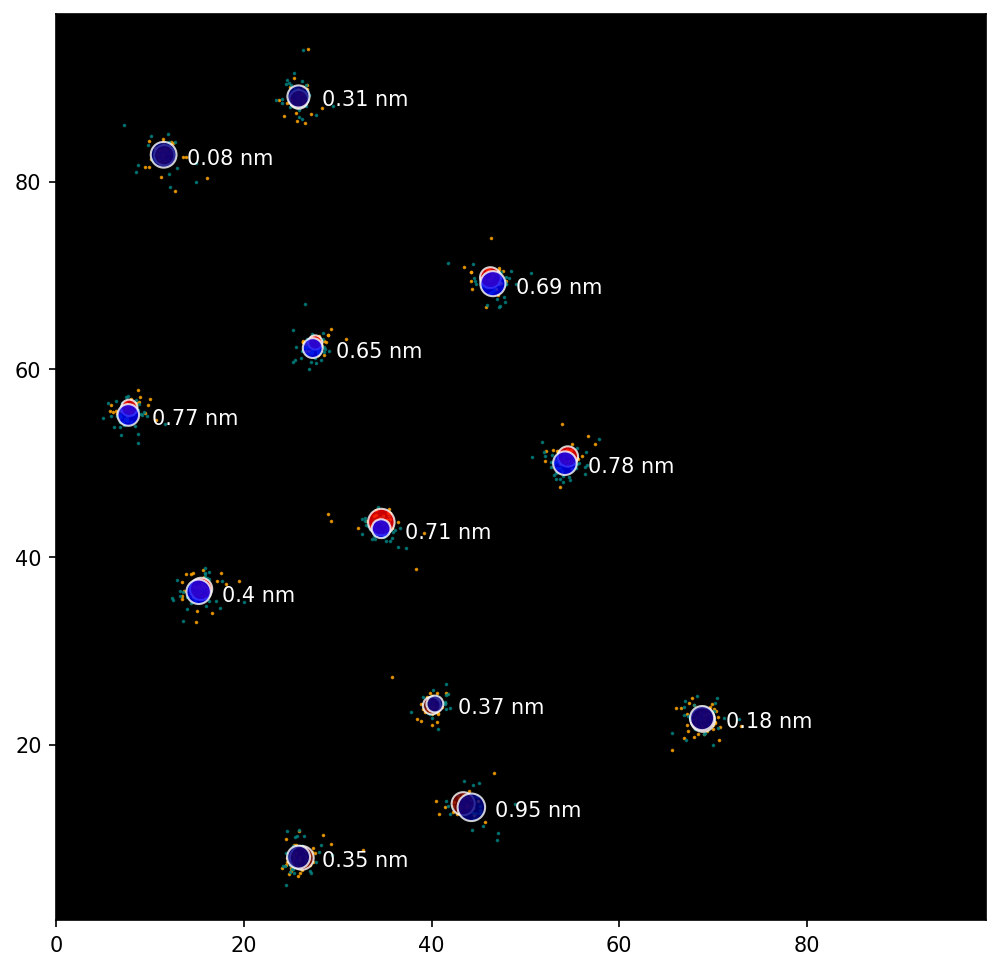

In [7]:
error_type = "STD"
color = "black"

size_inches = 8
dpi = 150

fig, ax = plt.subplots(figsize=(size_inches, size_inches), dpi=dpi)

ax.axis('equal')
ax.set_ylim(0, maxOuter)
ax.set_xlim(0, maxOuter)

if color == "black":
    ax.set_facecolor("black")
    alpha1 = 0.8
    alpha2 = 0.8
    edge = "white"
    textcol = "white"
elif color == "white":
    alpha1 = 0.2
    alpha2 = 0.4
    textcol = "black"
    edge = "black"

#Plot all the RESI cluster centers
ax.scatter(R1_table["x"], R1_table["y"], s=0.5, alpha=alpha1, color = "orange")
ax.scatter(R3_table["x"], R3_table["y"], s=0.5, alpha=alpha1, color = "teal")

if error_type == "STD":
    
    #Plot the R1 / R3 RESI averages with standard deviation
    circles(R1_resi, R1_resi_std_avg, "red", edge, False, alpha2, textcol, labels = [])
    circles(R3_resi, R3_resi_std_avg, "blue", edge, True, alpha2, textcol, labels = Resi_distances)

    #Plot the R4 RESI averages with standard deviation
    circles(R4_positions_R1_channel, R4_std_R1_channel_avg, "maroon", edge, 
            False, alpha2, textcol, labels = [])
    circles(R4_positions_R3_channel, R4_std_R3_channel_avg, "darkblue", edge, 
            True, alpha2, textcol, labels = R4_distances)

elif error_type == "FWHM":
    
    #Plot the R1 / R3 RESI averages with FWHM
    circles(R1_resi, R1_FWHM_avg, "red", False, labels = [])
    circles(R3_resi, R3_FWHM_avg, "blue", True, labels = Resi_distances)

    #Plot the R4 RESI averages with FWHM
    circles(R4_positions_R1_channel, R4_FWHM_R1_channel_avg, "maroon", 
            False, labels = [])
    circles(R4_positions_R3_channel, R4_FWHM_R3_channel_avg, "darkblue", 
            True, labels = R4_distances)
else:
    print("Invalid error representation")